In [260]:
# General imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
# from sklearn.preprocessing import normalize

# Neurophox imports
from neurophox.numpy import *
from neurophox.tensorflow import *
from neurophox.ml.nonlinearities import cnorm, cnormsq
from neurophox.initializers import *
from neurophox.components import *
from neurophox.helpers import *

In [262]:
plt.rcParams['text.usetex'] = True 
plt.rcParams['text.latex.preamble'] = r"\usepackage{siunitx} \usepackage{amsmath} \usepackage{sansmathfonts} \usepackage[T1]{fontenc} \renewcommand*\familydefault{\sfdefault}"

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def normalize(X):
    return X / abs(X).mean(axis=0, keepdims=True)

### Preprocessing

In [4]:
# Import dataset
(X_raw, y), (X_test_raw, y_test) = mnist.load_data()

def inputFFT(X_raw, X_test_raw, r):
    '''
        FTs the input images
    '''
    c = X_raw.shape[1] // 2

    # FTing the image data
    X_ft = np.fft.fftshift(np.fft.fft2(X_raw), axes=(1, 2))
    X_test_ft = np.fft.fftshift(np.fft.fft2(X_test_raw), axes=(1, 2))

    # Cropping out the outer pixels
    X_ft = X_ft[:, c-r:c+r, c-r-1:c+r]
    X_test_ft = X_test_ft[:, c-r:c+r, c-r-1:c+r]

    # Flatten image
    X_ft = X_ft.reshape(X_ft.shape[0], -1)
    X_test_ft = X_test_ft.reshape(X_test_ft.shape[0], -1)

    # Normalizing
    X_ft = normalize(X_ft).astype(np.complex64)
    X_test_ft = normalize(X_test_ft).astype(np.complex64)
    return X_ft, X_test_ft

X_ft, X_test_ft = inputFFT(X_raw, X_test_raw, 2)

# One-Hot encoding the labels
y = to_categorical(y)
y_test = to_categorical(y_test)

In [5]:
X_ft.shape

(60000, 20)

### Modelling

Activation function formula:

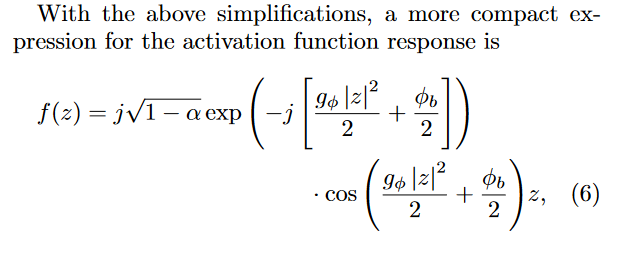

In [6]:
class EOIntensityModulation(tf.keras.layers.Layer):
    def __init__(self, N, alpha=0.1, g=np.pi, phi_b=np.pi, train_alpha=False, train_g=False, train_phi_b=False, single_param_per_layer=True):
        
        super(EOIntensityModulation, self).__init__()
        
        if single_param_per_layer:
            var_shape = [1]
        else:
            var_shape = [N]
        
        self.g = self.add_variable(shape=var_shape,
                                       name="g",
                                       initializer=tf.constant_initializer(g),
                                       trainable=train_g,
                                       constraint=lambda x: tf.clip_by_value(x, 1e-3, 1.5*np.pi))
        self.phi_b = self.add_variable(shape=var_shape,
                                       name="phi_b",
                                       initializer=tf.constant_initializer(phi_b),
                                       trainable=train_phi_b,
                                       constraint=lambda x: tf.clip_by_value(x, -np.pi, +np.pi))
        self.alpha = self.add_variable(shape=var_shape,
                                       name="alpha",
                                       initializer=tf.constant_initializer(alpha),
                                       trainable=train_alpha,
                                       constraint=lambda x: tf.clip_by_value(x, 0.01, 0.99))
    
    def call(self, inputs):
        alpha, g, phi_b = tf.complex(self.alpha, 0.0), tf.complex(self.g, 0.0), tf.complex(self.phi_b, 0.0)
        Z = inputs
        return 1j * tf.sqrt(1-alpha) * tf.exp(-1j*0.5*g*tf.math.conj(Z)*Z - 1j*0.5*phi_b) * tf.cos(0.5*g*tf.math.conj(Z)*Z + 0.5*phi_b) * Z

The procedure is summarised well by the following diagram.

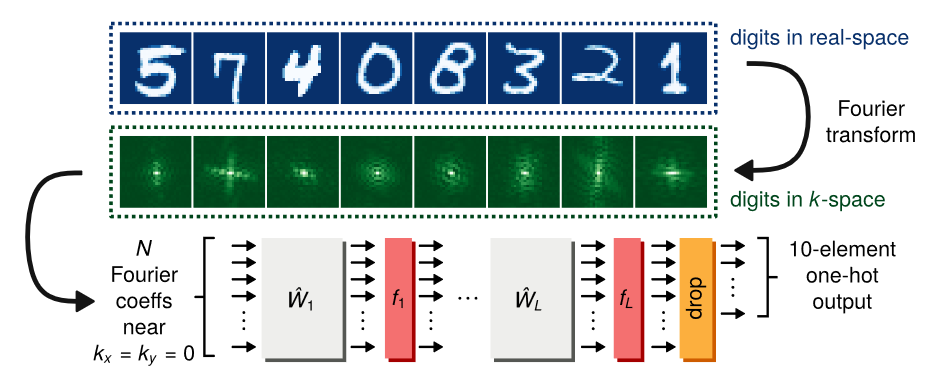

To get a better idea of the network layers -

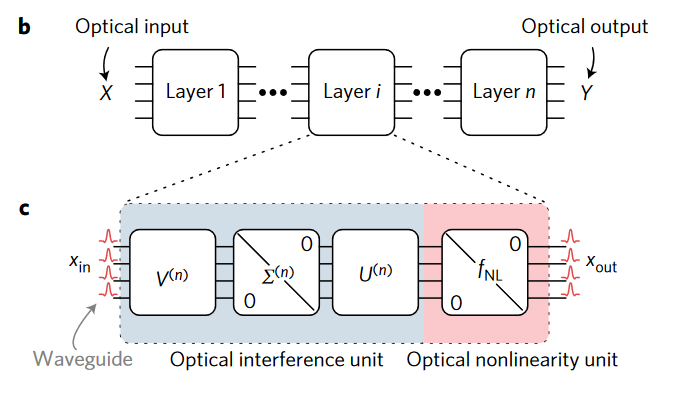

In [7]:
def generate_network(N, N_classes=10, L=1, theta_init_name='haar_rect', phi_init_name='random_phi', alpha=0.1, g=0.05*np.pi, phi_b=1*np.pi):
    """ Creates L layer ONN

    Args:
        N (int): Size of the input layer
        N_classes (int, optional): _description_. Defaults to 10.
        L (int, optional): _description_. Defaults to 1.
        theta_init_name (str, optional): _description_. Defaults to 'haar_rect'.
        phi_init_name (str, optional): _description_. Defaults to 'random_phi'.

    Returns:
        Sequential: _description_
    """
    layers=[]
    
    for _ in range(L):
        layers.append(RM(N, theta_init_name=theta_init_name, phi_init_name=phi_init_name))
        # layers.append(EOIntensityModulation(N, alpha, g, phi_b))
    
    layers.append(Activation(cnormsq))
    layers.append(Lambda(lambda x: tf.math.real(x[:, :N_classes])))
    layers.append(Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)))
    # layers.append(tf.keras.layers.Softmax(axis=-1))

    return Sequential(layers)

In [8]:
epochs = 200
batch_size = 512
N_classes = 10

### Simulating 64 modes with 3 layers

In [9]:
onn_model = generate_network(64, L=3)
onn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [8]:
history = onn_model.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/200
118/118 - 81s - loss: 0.0910 - accuracy: 0.2028 - val_loss: 0.0889 - val_accuracy: 0.2402 - 81s/epoch - 685ms/step
Epoch 2/200
118/118 - 34s - loss: 0.0781 - accuracy: 0.3034 - val_loss: 0.0731 - val_accuracy: 0.3253 - 34s/epoch - 288ms/step
Epoch 3/200
118/118 - 34s - loss: 0.0729 - accuracy: 0.3338 - val_loss: 0.0721 - val_accuracy: 0.3457 - 34s/epoch - 291ms/step
Epoch 4/200
118/118 - 41s - loss: 0.0699 - accuracy: 0.3685 - val_loss: 0.0646 - val_accuracy: 0.4128 - 41s/epoch - 349ms/step
Epoch 5/200
118/118 - 43s - loss: 0.0619 - accuracy: 0.4473 - val_loss: 0.0556 - val_accuracy: 0.4903 - 43s/epoch - 361ms/step
Epoch 6/200
118/118 - 42s - loss: 0.0544 - accuracy: 0.5232 - val_loss: 0.0483 - val_accuracy: 0.5959 - 42s/epoch - 359ms/step
Epoch 7/200
118/118 - 40s - loss: 0.0465 - accuracy: 0.6275 - val_loss: 0.0411 - val_accuracy: 0.6719 - 40s/epoch - 343ms/step
Epoch 8/200
118/118 - 34s - loss: 0.0345 - accuracy: 0.7360 - val_loss: 0.0310 - val_accuracy: 0.7574 - 34s/epo

---
### Simulating the Quix QPP

##### 20 modes with 1 layer

In [70]:
onn_model20_1 = generate_network(20, L=1)
onn_model20_1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history20_1 = onn_model20_1.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/200
118/118 - 10s - loss: 0.1225 - accuracy: 0.2957 - val_loss: 0.1012 - val_accuracy: 0.4747 - 10s/epoch - 84ms/step
Epoch 2/200
118/118 - 3s - loss: 0.0888 - accuracy: 0.5657 - val_loss: 0.0781 - val_accuracy: 0.6459 - 3s/epoch - 28ms/step
Epoch 3/200
118/118 - 3s - loss: 0.0743 - accuracy: 0.6645 - val_loss: 0.0695 - val_accuracy: 0.7006 - 3s/epoch - 28ms/step
Epoch 4/200
118/118 - 3s - loss: 0.0682 - accuracy: 0.7039 - val_loss: 0.0654 - val_accuracy: 0.7281 - 3s/epoch - 29ms/step
Epoch 5/200
118/118 - 3s - loss: 0.0647 - accuracy: 0.7264 - val_loss: 0.0625 - val_accuracy: 0.7452 - 3s/epoch - 28ms/step
Epoch 6/200
118/118 - 3s - loss: 0.0622 - accuracy: 0.7424 - val_loss: 0.0602 - val_accuracy: 0.7572 - 3s/epoch - 29ms/step
Epoch 7/200
118/118 - 3s - loss: 0.0601 - accuracy: 0.7534 - val_loss: 0.0583 - val_accuracy: 0.7710 - 3s/epoch - 29ms/step
Epoch 8/200
118/118 - 3s - loss: 0.0583 - accuracy: 0.7632 - val_loss: 0.0566 - val_accuracy: 0.7787 - 3s/epoch - 28ms/step
Epoch 

In [11]:
print("Best epoch:", np.argmax(history20_1.history['val_accuracy']))
print("Best accuracy:", f"{max(history20_1.history['val_accuracy'])*100:.2f}%")

Best epoch: 189
Best accuracy: 85.41%


##### 20 modes with 2 layers

In [17]:
onn_model20_2 = generate_network(20, L=2)
onn_model20_2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [18]:
history20_2 = onn_model20_2.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/200
118/118 - 18s - loss: 0.1080 - accuracy: 0.4041 - val_loss: 0.0779 - val_accuracy: 0.6205 - 18s/epoch - 150ms/step
Epoch 2/200
118/118 - 6s - loss: 0.0687 - accuracy: 0.6873 - val_loss: 0.0608 - val_accuracy: 0.7407 - 6s/epoch - 51ms/step
Epoch 3/200
118/118 - 6s - loss: 0.0581 - accuracy: 0.7572 - val_loss: 0.0540 - val_accuracy: 0.7844 - 6s/epoch - 49ms/step
Epoch 4/200
118/118 - 6s - loss: 0.0531 - accuracy: 0.7867 - val_loss: 0.0502 - val_accuracy: 0.8038 - 6s/epoch - 49ms/step
Epoch 5/200
118/118 - 6s - loss: 0.0500 - accuracy: 0.8044 - val_loss: 0.0478 - val_accuracy: 0.8170 - 6s/epoch - 49ms/step
Epoch 6/200
118/118 - 6s - loss: 0.0482 - accuracy: 0.8143 - val_loss: 0.0463 - val_accuracy: 0.8258 - 6s/epoch - 54ms/step
Epoch 7/200
118/118 - 6s - loss: 0.0470 - accuracy: 0.8213 - val_loss: 0.0454 - val_accuracy: 0.8328 - 6s/epoch - 53ms/step
Epoch 8/200
118/118 - 6s - loss: 0.0462 - accuracy: 0.8266 - val_loss: 0.0446 - val_accuracy: 0.8364 - 6s/epoch - 49ms/step
Epoch

In [35]:
print("Best epoch:", np.argmax(history20_2.history['val_accuracy']))
print("Best accuracy:", f"{max(history20_2.history['val_accuracy'])*100:.2f}%")

Best epoch: 152
Best accuracy: 85.96%


##### 49 modes with 1 layer

In [38]:
# Import dataset
(X_raw, y), (X_test_raw, y_test) = mnist.load_data()

def inputFFT(X_raw, X_test_raw, r):
    '''
        FTs the input images
    '''
    c = X_raw.shape[1] // 2

    # FTing the image data
    X_ft = np.fft.fftshift(np.fft.fft2(X_raw), axes=(1, 2))
    X_test_ft = np.fft.fftshift(np.fft.fft2(X_test_raw), axes=(1, 2))

    # Cropping out the outer pixels
    X_ft = X_ft[:, c-r-1:c+r, c-r-1:c+r]
    X_test_ft = X_test_ft[:, c-r-1:c+r, c-r-1:c+r]

    # Flatten image
    X_ft = X_ft.reshape(X_ft.shape[0], -1)
    X_test_ft = X_test_ft.reshape(X_test_ft.shape[0], -1)

    # Normalizing
    X_ft = normalize(X_ft).astype(np.complex64)
    X_test_ft = normalize(X_test_ft).astype(np.complex64)
    return X_ft, X_test_ft

X_ft, X_test_ft = inputFFT(X_raw, X_test_raw, 3)

# One-Hot encoding the labels
y = to_categorical(y)
y_test = to_categorical(y_test)

In [40]:
onn_model49_1 = generate_network(49, L=1)
onn_model49_1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history49_1 = onn_model49_1.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/200
118/118 - 18s - loss: 0.0985 - accuracy: 0.4624 - val_loss: 0.0641 - val_accuracy: 0.7065 - 18s/epoch - 156ms/step
Epoch 2/200
118/118 - 7s - loss: 0.0545 - accuracy: 0.7685 - val_loss: 0.0459 - val_accuracy: 0.8201 - 7s/epoch - 57ms/step
Epoch 3/200
118/118 - 7s - loss: 0.0438 - accuracy: 0.8324 - val_loss: 0.0398 - val_accuracy: 0.8541 - 7s/epoch - 55ms/step
Epoch 4/200
118/118 - 7s - loss: 0.0394 - accuracy: 0.8547 - val_loss: 0.0366 - val_accuracy: 0.8676 - 7s/epoch - 55ms/step
Epoch 5/200
118/118 - 6s - loss: 0.0369 - accuracy: 0.8647 - val_loss: 0.0347 - val_accuracy: 0.8767 - 6s/epoch - 55ms/step
Epoch 6/200
118/118 - 7s - loss: 0.0352 - accuracy: 0.8729 - val_loss: 0.0333 - val_accuracy: 0.8816 - 7s/epoch - 56ms/step
Epoch 7/200
118/118 - 6s - loss: 0.0339 - accuracy: 0.8785 - val_loss: 0.0323 - val_accuracy: 0.8876 - 6s/epoch - 54ms/step
Epoch 8/200
118/118 - 6s - loss: 0.0330 - accuracy: 0.8817 - val_loss: 0.0315 - val_accuracy: 0.8900 - 6s/epoch - 54ms/step
Epoch

In [41]:
print("Best epoch:", np.argmax(history49_1.history['val_accuracy']))
print("Best accuracy:", f"{max(history49_1.history['val_accuracy'])*100:.2f}%")

Best epoch: 127
Best accuracy: 91.80%


##### 49 modes with 2 layers

In [42]:
onn_model49_2 = generate_network(49, L=2)
onn_model49_2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history49_2 = onn_model49_2.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/200
118/118 - 79s - loss: 0.0796 - accuracy: 0.5849 - val_loss: 0.0448 - val_accuracy: 0.8148 - 79s/epoch - 665ms/step
Epoch 2/200
118/118 - 16s - loss: 0.0384 - accuracy: 0.8499 - val_loss: 0.0332 - val_accuracy: 0.8782 - 16s/epoch - 133ms/step
Epoch 3/200
118/118 - 16s - loss: 0.0324 - accuracy: 0.8803 - val_loss: 0.0302 - val_accuracy: 0.8931 - 16s/epoch - 135ms/step
Epoch 4/200
118/118 - 16s - loss: 0.0305 - accuracy: 0.8894 - val_loss: 0.0290 - val_accuracy: 0.8999 - 16s/epoch - 135ms/step
Epoch 5/200
118/118 - 16s - loss: 0.0295 - accuracy: 0.8937 - val_loss: 0.0285 - val_accuracy: 0.9006 - 16s/epoch - 133ms/step
Epoch 6/200
118/118 - 16s - loss: 0.0289 - accuracy: 0.8966 - val_loss: 0.0277 - val_accuracy: 0.9050 - 16s/epoch - 136ms/step
Epoch 7/200
118/118 - 16s - loss: 0.0283 - accuracy: 0.8991 - val_loss: 0.0272 - val_accuracy: 0.9057 - 16s/epoch - 132ms/step
Epoch 8/200
118/118 - 16s - loss: 0.0279 - accuracy: 0.9013 - val_loss: 0.0268 - val_accuracy: 0.9072 - 16s/epo

In [43]:
print("Best epoch:", np.argmax(history49_2.history['val_accuracy']))
print("Best accuracy:", f"{max(history49_2.history['val_accuracy'])*100:.2f}%")

Best epoch: 141
Best accuracy: 91.73%


In [53]:
X_ft.shape

(60000, 64)

##### 64 modes with 1 layer

In [52]:
# Import dataset
(X_raw, y), (X_test_raw, y_test) = mnist.load_data()

def inputFFT(X_raw, X_test_raw, r):
    '''
        FTs the input images
    '''
    c = X_raw.shape[1] // 2

    # FTing the image data
    X_ft = np.fft.fftshift(np.fft.fft2(X_raw), axes=(1, 2))
    X_test_ft = np.fft.fftshift(np.fft.fft2(X_test_raw), axes=(1, 2))

    # Cropping out the outer pixels
    X_ft = X_ft[:, c-r:c+r, c-r:c+r]
    X_test_ft = X_test_ft[:, c-r:c+r, c-r:c+r]

    # Flatten image
    X_ft = X_ft.reshape(X_ft.shape[0], -1)
    X_test_ft = X_test_ft.reshape(X_test_ft.shape[0], -1)

    # Normalizing
    X_ft = normalize(X_ft).astype(np.complex64)
    X_test_ft = normalize(X_test_ft).astype(np.complex64)
    return X_ft, X_test_ft

X_ft, X_test_ft = inputFFT(X_raw, X_test_raw, 4)

# One-Hot encoding the labels
y = to_categorical(y)
y_test = to_categorical(y_test)

In [54]:
onn_model64_1 = generate_network(64, L=1)
onn_model64_1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history64_1 = onn_model64_1.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/200
118/118 - 23s - loss: 0.0905 - accuracy: 0.5121 - val_loss: 0.0541 - val_accuracy: 0.7520 - 23s/epoch - 192ms/step
Epoch 2/200
118/118 - 7s - loss: 0.0466 - accuracy: 0.7977 - val_loss: 0.0389 - val_accuracy: 0.8441 - 7s/epoch - 63ms/step
Epoch 3/200
118/118 - 8s - loss: 0.0374 - accuracy: 0.8513 - val_loss: 0.0337 - val_accuracy: 0.8729 - 8s/epoch - 65ms/step
Epoch 4/200
118/118 - 7s - loss: 0.0335 - accuracy: 0.8725 - val_loss: 0.0309 - val_accuracy: 0.8884 - 7s/epoch - 63ms/step
Epoch 5/200
118/118 - 7s - loss: 0.0313 - accuracy: 0.8826 - val_loss: 0.0295 - val_accuracy: 0.8929 - 7s/epoch - 63ms/step
Epoch 6/200
118/118 - 7s - loss: 0.0299 - accuracy: 0.8891 - val_loss: 0.0285 - val_accuracy: 0.8994 - 7s/epoch - 62ms/step
Epoch 7/200
118/118 - 7s - loss: 0.0290 - accuracy: 0.8932 - val_loss: 0.0276 - val_accuracy: 0.9017 - 7s/epoch - 62ms/step
Epoch 8/200
118/118 - 7s - loss: 0.0283 - accuracy: 0.8960 - val_loss: 0.0270 - val_accuracy: 0.9038 - 7s/epoch - 63ms/step
Epoch

In [56]:
print("Best epoch:", np.argmax(history64_1.history['val_accuracy']))
print("Best accuracy:", f"{max(history64_1.history['val_accuracy'])*100:.2f}%")

Best epoch: 184
Best accuracy: 92.30%


#### Scale, Delay and Power Consumption

| Input Dim (N) | No. of Mesh Layers (L) | Epochs | Test Acc |
|:-------------:|:----------------------:|:------:|:--------:|
|       64      |            1           |   200  |   92.30  |
|       64      |            2           |   200  |    96    |
|       64      |            3           |   200  |   97.38  |
|       64      |            4           |   200  |    ??    |



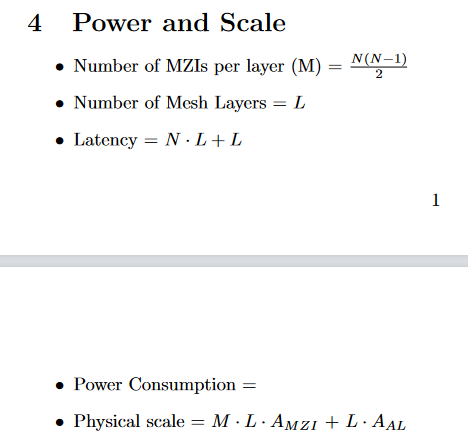

- $N = 64$
- MZIs per layer $(M)$ = 2016
- $L = 2$

Total = 4032 MZIs



---
### Playing around with mesh layers

Basic unit simulation
$$ U_2(\theta, \phi) = B \cdot R(\theta) \cdot B \cdot R(\phi) = i \begin{bmatrix} e^{i \phi}\sin \frac{\theta}{2} & \cos \frac{\theta}{2} \\\\
        e^{i \phi}\cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \end{bmatrix} $$
![Alt text](image.png)

In [ ]:
mzi.BlochMZI(0, 0, False).matrix # This is the most fundamental unit of computation for the mesh layers

array([[0.+0.j, 0.+1.j],
       [0.+1.j, 0.+0.j]])

In [ ]:
input = 4
depth = 5
layer = RMNumpy(input, depth)
type(layer)

neurophox.numpy.layers.RMNumpy

Phases are stored in arrays of size `(depth, input // 2)`

We need to store half the input amount of phases as each MZI has 2 input ports and is characterised by a single pair of $(\theta, \phi)$.

In [ ]:
layer.theta.T

array([[0.5808689 , 0.40803068, 0.93953515, 1.87063208, 1.46720983],
       [2.65388288, 0.        , 0.15391314, 0.        , 2.12988061]])

In [ ]:
layer.phi.T

array([[4.68224897, 5.92223638, 0.62535491, 1.3717976 , 4.87874205],
       [1.02387983, 3.66936286, 0.92077258, 4.268002  , 2.62449535]])

In [ ]:
layer.gamma.T

array([[1.1082804 ],
       [1.9430582 ],
       [5.02199356],
       [5.39584577]])

In [ ]:
layer.phases.internal_phase_shifts

array([[ 0.29043445,  0.20401534,  0.46976758,  0.93531604,  0.73360492],
       [-0.29043445, -0.20401534, -0.46976758, -0.93531604, -0.73360492],
       [ 1.32694144,  1.57079633,  0.07695657,  1.57079633,  1.06494031],
       [-1.32694144, -1.57079633, -0.07695657, -1.57079633, -1.06494031]])

In [286]:
units = 5
d = 2
thetaphi = ConstantPhaseInitializer(units, d, np.pi/4).to_np() # 
gam = ConstantPhaseInitializer(2*units, 1, 0).to_np()

In [287]:
mesh_phases = MeshPhases(thetaphi, thetaphi, gam)

In [292]:
mesh_phases.theta.param

array([[0.78539816, 0.78539816],
       [0.78539816, 0.78539816]])

We can create the `MeshPhases` objects and use them as inputs for our mesh layers. 

Hence, we can set some custom phase values for our mesh network.

---
### Effect of Phase Error on Inference

Background:
- Neurophox trains a model with ideal mesh layers (no error in phase and beamsplitters)
- We can encode the trained weight matrices onto our device and perform inference
- The phases in our device will not be exact due to thermal noise
- It is therefore worth investigating how **tolerant** the mesh networks are to fluctuations in phase

Approach:
- The trained ideal ONN model for 20 modes and 1 layer has an accuracy of $84.46$%
- Vary the amount of phase noise in the above model and observe the effects on accuracy


In [ ]:
# Extracting the exact phases of our layers
exactTheta = onn_model20_1.layers[0].theta
exactPhi = onn_model20_1.layers[0].phi
exactGamma = onn_model20_1.layers[0].gamma

- For a thermo-optic phase shifter, $ \phi \propto \Delta T$, where $\phi$ is the phase change and $\Delta T$ is the temperature change.
- Change in temperature of the phase shifter is proportional to power consumed $P$. 
- I will model the noise in $P$ as Gaussian white noise.

$$ \Delta \phi = \pi \frac{P_N}{P_\pi}$$


##### Case 1: 
I am assuming that the standard deviation of the noise will be according to the variance of phase.

In [195]:
def addNoiseSNR(param, snr):
    var = np.mean(param.numpy()**2)
    noise = np.random.normal(0, np.sqrt(var * 10**(-snr/10)), param.numpy().shape)
    noisy = param + noise
    return tf.Variable(noisy, name=param.name[:-2])

def addNoiseEpsilon(param, eps):
    noise = eps * np.random.normal(0, 1, param.numpy().shape)
    noisy = param + noise
    return tf.Variable(noisy, name=param.name[:-2])

In [233]:
def generate_network_error(N, theta, phi, gamma, N_classes=10, L=1):
    """Creates the ONN model with phase noise

    Args:
        N (int): _description_
        theta (tf.Variable): _description_
        phi (tf.Variable): _description_
        gamma (tf.Variable): _description_
        N_classes (int, optional): _description_. Defaults to 10.
        L (int, optional): _description_. Defaults to 1.

    Returns:
        Sequential: _description_
    """
    layers=[]

    layers.append(RM(N))
    layers[0].theta = theta
    layers[0].phi = phi
    layers[0].gamma = gamma
    
    layers.append(Activation(cnormsq))
    layers.append(Lambda(lambda x: tf.math.real(x[:, :N_classes])))
    layers.append(Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)))
    # layers.append(tf.keras.layers.Softmax(axis=-1))

    return Sequential(layers)

In [267]:
snr = -10
noisyTheta = addNoiseSNR(exactTheta, snr)
noisyPhi = addNoiseSNR(exactPhi, snr)

In [274]:
noisy_onn = generate_network_error(20, noisyTheta, noisyPhi, exactGamma)
noisy_onn.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
print(f'Accuracy of noisy ONN with SNR = {snr} dB : {noisy_onn.evaluate(X_test_ft, y_test)[1]*100:.2f}%')
print(f'Accuracy of ideal ONN : 84.46%')

313/313 [==============================] - 3s 8ms/step - loss: 0.1550 - accuracy: 0.0879
Accuracy of noisy ONN with SNR = -10 dB : 8.79%
Accuracy of ideal ONN : 84.46%


##### Case 2: 
Here, error is modelled as $$Y= X + \epsilon  N(0, 1)$$

In [271]:
eps = 0.1
noisyTheta1 = addNoiseEpsilon(exactTheta, eps)
noisyPhi1 = addNoiseEpsilon(exactPhi, eps)

In [275]:
noisy_onn1 = generate_network_error(20, noisyTheta1, noisyPhi1, exactGamma)
noisy_onn1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
print(f'Accuracy of noisy ONN with epsilon = {eps} : {100*noisy_onn1.evaluate(X_test_ft, y_test)[1]:.2f}%')
print(f'Accuracy of ideal ONN : 84.46%')

313/313 [==============================] - 3s 8ms/step - loss: 0.1381 - accuracy: 0.1666
Accuracy of noisy ONN with epsilon = 0.1 : 16.66%
Accuracy of ideal ONN : 84.46%


In [206]:
snr_list = np.linspace(-10, 40, 51)

In [212]:
snr_acc = []
for s in snr_list:
    acc = 0
    for _ in range(5):
        nth = addNoiseSNR(exactTheta, s)
        nphi = addNoiseSNR(exactPhi, s)
        onn = generate_network_error(20, nth, nphi, exactGamma)
        onn.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        acc += onn.evaluate(X_test_ft, y_test, verbose=0)[1]
    snr_acc.append(acc/5)

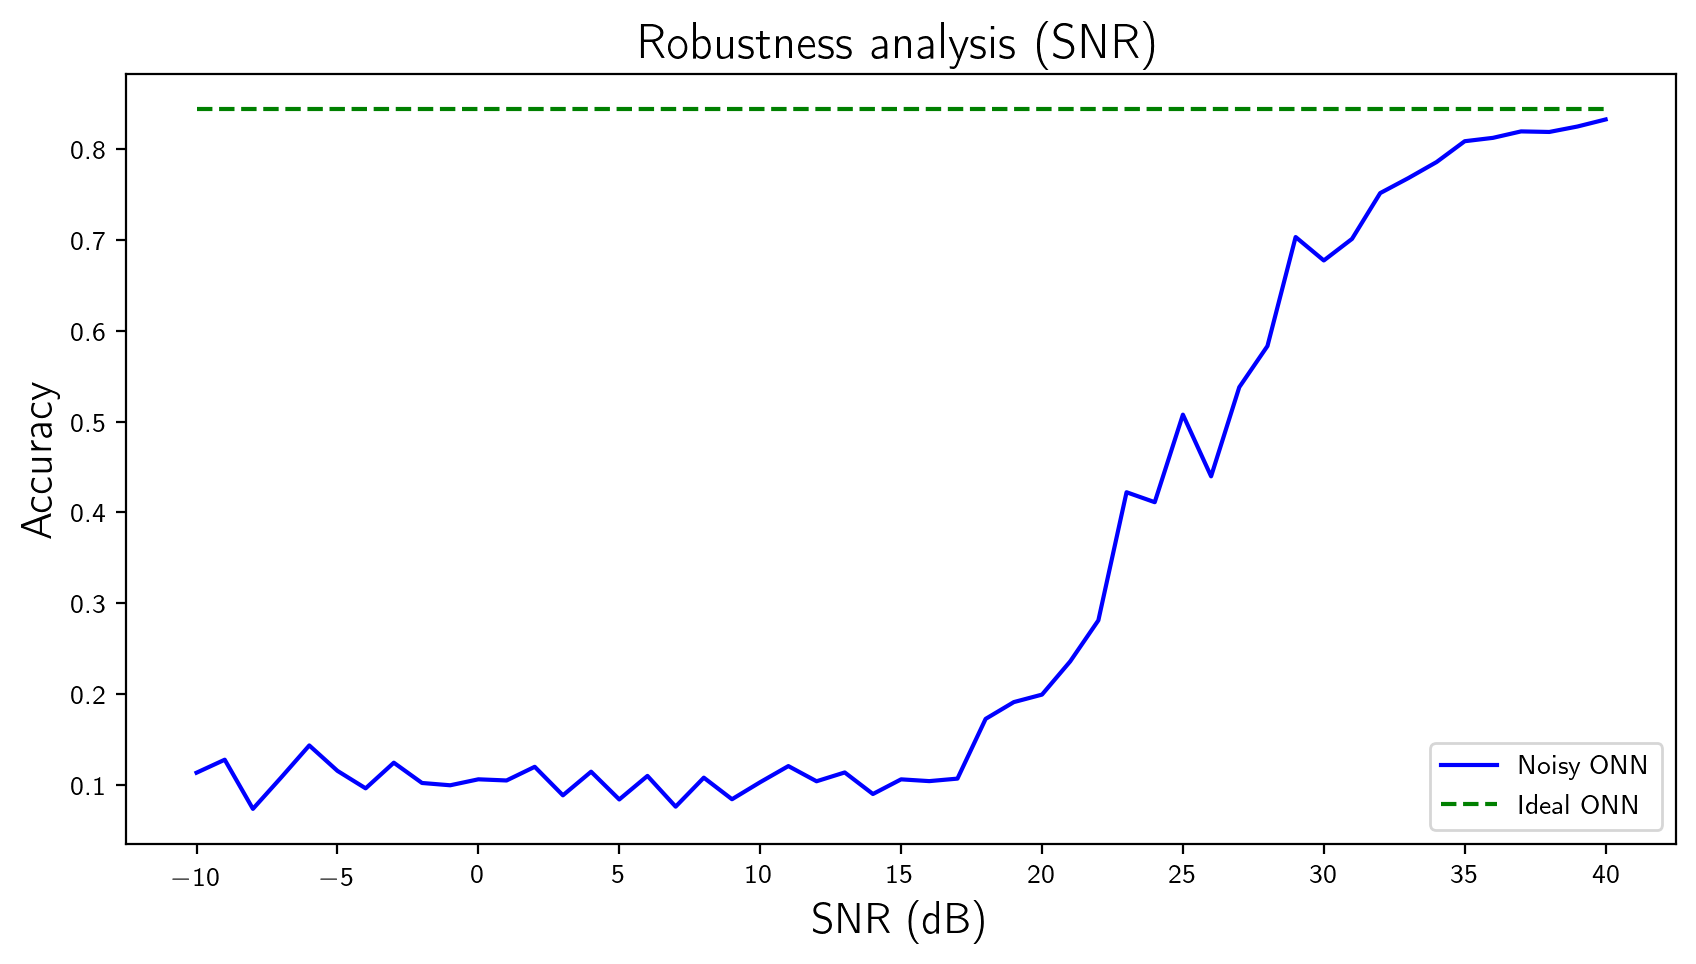

In [263]:
plt.figure(dpi=200, figsize=(10, 5))
plt.plot(snr_list, snr_acc, color='blue', label='Noisy ONN')
plt.plot(snr_list, [0.8446]*51, c='green', linestyle='--', label='Ideal ONN')
plt.xlabel(r'SNR (dB)', fontsize=16)
plt.ylabel(r'Accuracy', fontsize=16)
plt.title('Robustness analysis (SNR)', fontsize=18)
plt.xticks(np.arange(-10, 45, 5))
plt.legend()
plt.show()

In [250]:
eps_list = np.arange(0.005, 0.205, 0.005)
eps_acc = []
for e in eps_list:
    acc = 0
    for _ in range(5):
        nth = addNoiseEpsilon(exactTheta, e)
        nphi = addNoiseEpsilon(exactPhi, e)
        onn = generate_network_error(20, nth, nphi, exactGamma)
        onn.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        acc += onn.evaluate(X_test_ft, y_test, verbose=0)[1]
    eps_acc.append(acc/5)

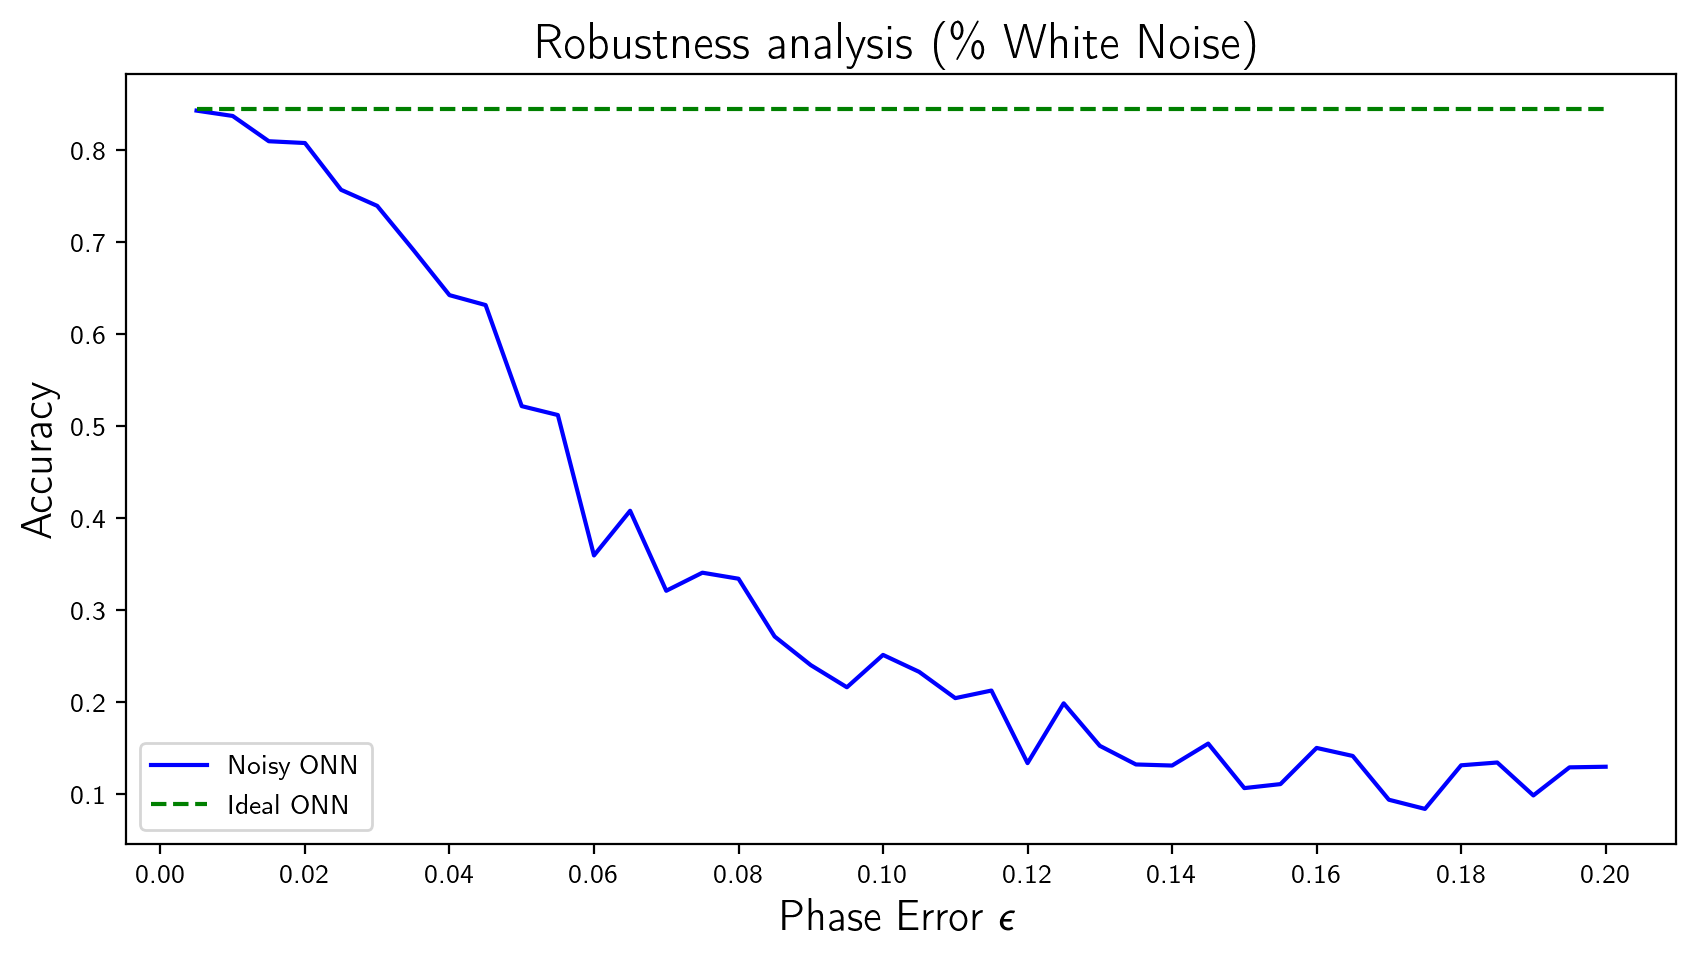

In [265]:
plt.figure(dpi=200, figsize=(10, 5))
plt.plot(eps_list, eps_acc, color='blue', label='Noisy ONN')
plt.plot(eps_list, [0.8446]*40, c='green', linestyle='--', label='Ideal ONN')
plt.xlabel(r'Phase Error $\epsilon$', fontsize=16)
plt.ylabel(r'Accuracy', fontsize=16)
plt.title(r'Robustness analysis (\% White Noise)', fontsize=18)
plt.xticks(np.arange(0, 0.22, 0.02))
plt.legend()
plt.show()


---
### Multicore PNN (Work in progress)

In [ ]:
def generate_network_multicore(N, N_classes=10, L=1, theta_init_name='haar_rect', phi_init_name='random_phi', alpha=0.1, g=0.05*np.pi, phi_b=1*np.pi):
    """ Creates L layer ONN

    Args:
        N (int): Size of the input layer
        N_classes (int, optional): _description_. Defaults to 10.
        L (int, optional): _description_. Defaults to 1.
        theta_init_name (str, optional): _description_. Defaults to 'haar_rect'.
        phi_init_name (str, optional): _description_. Defaults to 'random_phi'.

    Returns:
        Sequential: _description_
    """
    layers=[]
    
    for _ in range(L):
        layers.append(RM(N, theta_init_name=theta_init_name, phi_init_name=phi_init_name))
        # layers.append(EOIntensityModulation(N, alpha, g, phi_b))
    
    layers.append(Activation(cnormsq))
    layers.append(Lambda(lambda x: tf.math.real(x[:, :N_classes])))
    layers.append(Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)))
    # layers.append(tf.keras.layers.Softmax(axis=-1))

    return Sequential(layers)